In [1]:
# Purpose: Plotting the overturning streamfunction in the ACCESS-OM2-1 model 
#          using ty_trans and ty_trans_gm and the steps laid out in the
#          cosima_cookbook script
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 07. 09. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import matplotlib.patheffects as PathEffects
from scipy import stats


# from matplotlib.colors import DivergingNorm # for white at the middle of the colour bar

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime

from cdo import *
cdo = Cdo()
import os
import sys
# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:40123 Dashboard: /proxy/37423/status,Cluster Workers: 16 Cores: 16 Memory: 250.00 GiB


### Load in single temperature file

In [2]:
input = '/g/data/e14/mv7494/HeatDist_input/'
xr.open_dataset(input + 'JRA55-do_basin_masks_for_perturbation_runs.nc')

<xarray.Dataset>
Dimensions:                     (lat: 320, lon: 640)
Coordinates:
    time                        datetime64[ns] ...
  * lat                         (lat) float64 -89.57 -89.01 ... 89.01 89.57
  * lon                         (lon) float64 0.0 0.5625 1.125 ... 358.9 359.4
    height                      float64 ...
Data variables: (12/17)
    tas                         (lat, lon) float32 ...
    iaf_mask_pacific            (lat, lon) float32 ...
    iaf_mask_atlantic           (lat, lon) float32 ...
    iaf_mask_indian             (lat, lon) float32 ...
    iaf_mask_southern           (lat, lon) float32 ...
    iaf_mask_northern           (lat, lon) float32 ...
    ...                          ...
    rdf_mask_indian             (lat, lon) float32 ...
    rdf_mask_southern           (lat, lon) float32 ...
    rdf_mask_northern           (lat, lon) float32 ...
    rdf_mask_tropics_30SN       (lat, lon) float32 ...
    rdf_mask_extratropics_30SN  (lat, lon) float32 ...
    rdf_mask_wind               (lat, lon) float32 ...

### Density Space: load in ty_trans, calculate overturning streamfunction and plot

CPU times: user 2.14 s, sys: 478 ms, total: 2.62 s
Wall time: 9.22 s


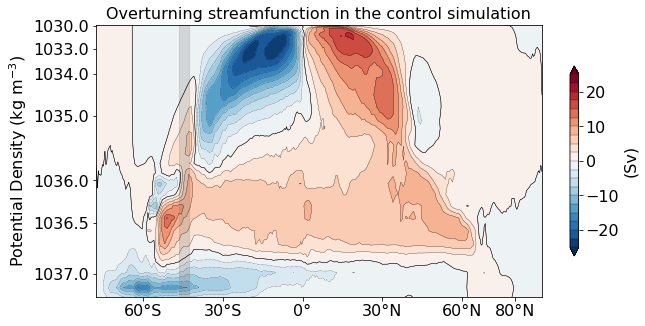

In [3]:
%%time
psi = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').ty_trans_rho.sum('grid_xt_ocean').sel(time = slice('1972-01','2017-12')) 
psiGM = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').ty_trans_rho_gm.sum('grid_xt_ocean').sel(time = slice('1972-01','2017-12')) 

# convert from kg m**-1 to Sv
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
psiGM = psiGM / (1e6*rho)


# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
psi_avg = psi_avg + psiGM.mean('time')
psi_avg.load()


# ---------------------------------------------------------------------------------------------------------- #
# Plotting routine
# ---------------------------------------------------------------------------------------------------------- #

fig,ax1 = plt.subplots(1,1,figsize=(10, 5))
ticks = np.linspace(-25,25,21)
yticks = np.array([1030, 1033, 1034, 1035, 1036,1036.5, 1037])
plot_range = [-80, 80]

scfac = 4  ## A power to set the stretching
p1=ax1.contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap='RdBu_r', levels=ticks, extend='both')

# add colour bar
#cax = fig.add_axes([0.075, -.01, 0.25, 0.015]) # position: [x0, y0, width, height]
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
cb.set_label(label='(Sv)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()  

p11a = ax1.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=ticks, colors='k', linewidths=0.25)
p11 = ax1.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
cb.add_lines(p11a) # add contours to colour bar
#cb.add_lines(p11) 

ax1.set_yticks((yticks-1028)**scfac)
ax1.set_yticklabels(yticks)
ax1.set_ylim([0.5**scfac, 9.2**scfac])

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent

ax1.invert_yaxis()
ax1.set_ylabel('Potential Density (kg m$^{-3}$)', fontsize=16);


ax1.set_xticks([-80,-60,-30,0,30,60,80])
ax1.set_xticklabels(['80°S','60°S','30°S','0°','30°N','60°N','80°N'], minor=False)

# shade tapering zones at 30°S-25°S and 25°N-30°N 
# ax1.axvspan(-33.5-3.96,-33.5, color=rotblau[3], alpha=.5); #ax1.axvspan(40,45, color='grey', alpha=.25)
ax1.axvspan(-42.5-3.96,-42.5, color='grey', alpha=.25); #ax1.axvspan(40,45, color='grey', alpha=.25)



ax1.set_title('Overturning streamfunction in the control simulation', fontsize=16)

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'ACCESS-OM2-1_control_overturning_streamfunction', 
            dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

# Wall time: 5.39 s

### Temperatur Space: load in ty_trans and calculate basin-wide overturning streamfunction and trends

In [4]:
%%time
# list of all perturbation experiments
run    = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/',
          '1deg_jra55_iaf_branch2000_PI_Offset/', '1deg_jra55_iaf_branch2000_Southern_PI_Offset/', '1deg_jra55_iaf_branch2000_Northern_PI_Offset/',
          '1deg_jra55_iaf_branch2000_Tropics30SN_PI_Offset/', '1deg_jra55_iaf_branch2000_Wind_PI_Offset/', '1deg_jra55_iaf_branch2000_TempRad_PI_Offset/',
          '1deg_jra55_iaf_branch2000_Pacific_PI_Offset/','1deg_jra55_iaf_branch2000_Indian_PI_Offset/','1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/'] 
suffix = ['ctrl_PI_Offset','iaf_PI_Offset','Southern_PI_Offset','Northern_PI_Offset','Tropics30SN_PI_Offset',
          'Wind_PI_Offset','TempRad_PI_Offset','Pacific_PI_Offset','Indian_PI_Offset','Atlantic_PI_Offset']
out = '1deg_jra55_iaf_branch2000_trend/' 
 
for f in [0,1,2,3,5,6,7,8,9]: # loop over perturbation simulations
    if f >= 1:
        print('calculating streamfunction and anomalous trend for:')
        print(run[f])
        print('------------------------------------------------------'); print('')
    
    # prepare basin_mask
#     if f == 1: # Pacific Ocean
#         basin_mask = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/ACCESS-OM2-1_basin_masks_for_perturbation_runs_1deg_resolution.nc').pacific_sector_map
#     elif f == 2: # Atlantic Ocean
#         basin_mask = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/ACCESS-OM2-1_basin_masks_for_perturbation_runs_1deg_resolution.nc').atlantic_sector_map
#     elif f == 3: # Indian Ocean
#         basin_mask = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/ACCESS-OM2-1_basin_masks_for_perturbation_runs_1deg_resolution.nc').indian_sector_map
#     else:
    basin_mask = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/ACCESS-OM2-1_basin_masks_for_perturbation_runs_1deg_resolution.nc').full_map      
  

    for i in range(2):
        if i == 0: # control run data
            psi = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc').ty_trans_rho.sel(time = slice('1972-01','2017-12')) 
            psiGM = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc').ty_trans_rho_gm.sel(time = slice('1972-01','2017-12')) 

#             psi = xr.open_mfdataset(base+run[0]+'/output*/ocean/ocean_wmass.nc').ty_trans_nrho.rename({'grid_yu_ocean': 'yt_ocean', 'grid_xt_ocean': 'xt_ocean'})
#             psiGM = xr.open_mfdataset(base+run[0]+'/output*/ocean/ocean_wmass.nc').ty_trans_nrho_gm.rename({'grid_yu_ocean': 'yt_ocean', 'grid_xt_ocean': 'xt_ocean'})
        else: # IAF run data
            psi = xr.open_mfdataset(base+run[f]+'output*/ocean/ocean.nc').ty_trans_rho.sel(time = slice('1972-01','2017-12')) 
            psiGM = xr.open_mfdataset(base+run[f]+'output*/ocean/ocean.nc').ty_trans_rho_gm.sel(time = slice('1972-01','2017-12')) 
        
        psi = psi.rename({'grid_xt_ocean': 'xt_ocean', 'grid_yu_ocean': 'yt_ocean'}) # rename coordinate so that I can multiply with basin_mask
        psiGM = psiGM.rename({'grid_xt_ocean': 'xt_ocean', 'grid_yu_ocean': 'yt_ocean'}) # rename coordinate so that I can multiply with basin_mask

#         basin_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values # copy over 64 float values from psi array so I can multiply the two
#         psi = psi*basin_mask

        psi = psi.sel(time = slice('1972-01','2017-12')) 
        psiGM = psiGM.sel(time = slice('1972-01','2017-12')) 

        # convert from kg m**-1 to Sv
        rho = 1025 # mean density of sea-water in kg/m^3
        psi = psi / (1e6*rho) # converts kg/s to Sv
        psiGM = psiGM / (1e6*rho)



        # Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
        # computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
        # we then load the variable to force the computation to occur.
        psi_avg = psi.cumsum('potrho') - psi.sum('potrho')
        psi_avg = psi_avg + psiGM.mean('time') 
        psi_avg = psi_avg.to_dataset(name='psi_avg') # prepare as netcdf

        

        if i == 0: # when ctrl run, calculate the linear trend
            os.system('rm -r '+base+out+'overturning_streamfunction_'+suffix[0]+'.nc') # delete file if it already exists
            psi_avg.to_netcdf(base+out+'overturning_streamfunction_'+suffix[0]+'.nc')
            # calculate linear trend in the control
            cdo.trend(input  = base+out+'overturning_streamfunction_'+suffix[0]+'.nc',
                      output = base+out+'intercept_overturning_streamfunction_'+suffix[0]+'.nc ' +
                      base+out+'trend_overturning_streamfunction_'+suffix[0]+'.nc', force=False)
        else:
            os.system('rm -r '+base+out+'overturning_streamfunction_'+suffix[f]+'.nc') 
            psi_avg.to_netcdf(base+out+'overturning_streamfunction_'+suffix[f]+'.nc')                
    

    # subtract linear trend from the control
    if f > 0:
        cdo.trend(input  = '-subtrend '+base+out+'overturning_streamfunction_'+suffix[f]+'.nc ' + 
                  base+out+'intercept_overturning_streamfunction_'+suffix[0]+'.nc ' +
                  base+out+'trend_overturning_streamfunction_'+suffix[0]+'.nc',
                  output = base+out+'intercept_overturning_streamfunction_'+suffix[f]+'.nc ' +
                  base+out+'trend_overturning_streamfunction_'+suffix[f]+'.nc', force=False)
        os.system('rm -r '+base+out+'intercept_overturning_streamfunction_'+suffix[f]+'.nc') 
#     if suffix[f] == 'iaf':
#         cdo.subtrend(input  = base+out+'overturning_streamfunction_iaf.nc ' + 
#                           base+out+'intercept_overturning_streamfunction_'+suffix[0]+'.nc ' +
#                           base+out+'trend_overturning_streamfunction_'+suffix[0]+'.nc',
#                           output = base+out+'overturning_streamfunction_iaf_clim_trend_removed.nc', force=False) 
# Wall time: 

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_Southern_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_Northern_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_Wind_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_TempRad_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_Pacific_PI_Offset/
------------------------------------------------------

calculating streamfunction and anomalous trend for:
1deg_jra55_iaf_branch2000_Indian_PI_Off

### Check if all done correctly

CPU times: user 402 ms, sys: 1.59 s, total: 1.99 s
Wall time: 1.78 s


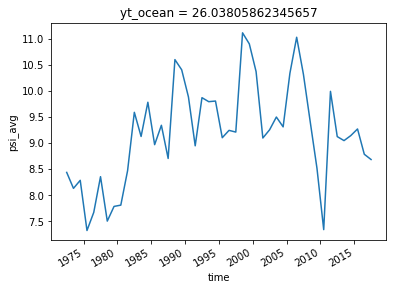

In [5]:
%%time
data = xr.open_dataset(base+out+'overturning_streamfunction_iaf_PI_Offset.nc') # multiply with (-1) so that the NH overturning circulation
data = data.where(data !=0).isel(yt_ocean=192).isel(xt_ocean=slice(173,278)) # -108°E (103°W) to -5°E (5°W) at RAPID array 26°N, going a bit further into land to make sure I get all the ocean grid cells
data.sum('xt_ocean').isel(potrho=slice(52,75)).psi_avg.max('potrho').plot()
# Wall time: 1.64 s

### Create three panels with (a) IAF raw data, (b) RDF ctrl trend, (c) IAF trend removed

CPU times: user 3.09 s, sys: 1.7 s, total: 4.79 s
Wall time: 4.28 s


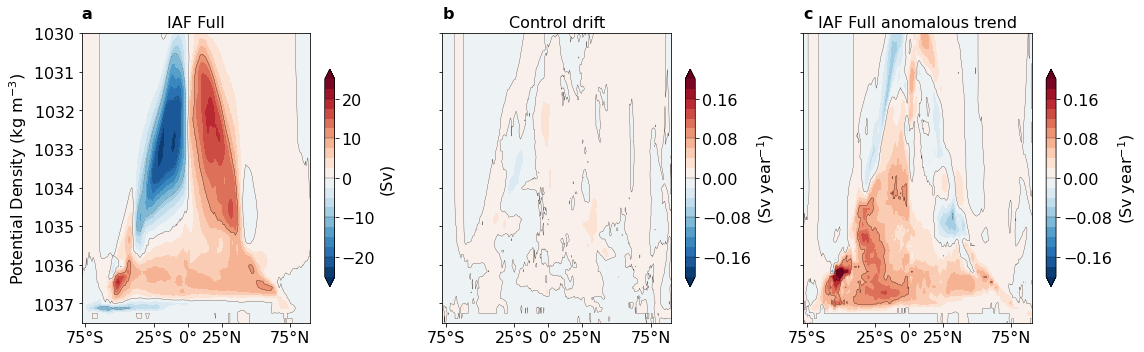

In [6]:
%%time
#yticks = [-3,0,5,10,15,20,25,30]
plot_range = [-80, 80]

# initialise figure
fig = plt.figure(figsize=(16, 5),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(1,3) 

scfac = 4  ## A power to set the stretching
# def fancy_plot(data, title): # initialise fancy_plot function
for f in range(3):
    if f == 0:
        data = xr.open_dataset(base+out+'overturning_streamfunction_iaf_PI_Offset.nc').psi_avg.mean(['time']).sum(['xt_ocean']) # multiply with (-1) so that the NH overturning circulation
        title = 'IAF Full'
        RAPID = np.round(data.where(data !=0).isel(yt_ocean=192).mean(['potrho']).values,3) # replace all zeroes with NaN and calculate the mean transport across 26°N 
        panel = gs[0,0]
        ticks = np.linspace(-25,25,21); cont = [-20,-10,0,10,20]
        unit = 'Sv'
    if f == 1:
        data = xr.open_dataset(base+out+'trend_overturning_streamfunction_ctrl_PI_Offset.nc').psi_avg[0,:,:].sum(['xt_ocean'])
        title = 'Control drift'
        RAPID = np.round(data.where(data !=0).isel(yt_ocean=192).mean(['potrho']).values,3)
        panel = gs[0,1]
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
        unit = 'Sv year$^{-1}$'
    if f == 2:
        data =  xr.open_dataset(base+out+'trend_overturning_streamfunction_iaf_PI_Offset.nc').psi_avg[0,:,:].sum(['xt_ocean'])
        title = 'IAF Full anomalous trend'
        RAPID = np.round(data.where(data !=0).isel(yt_ocean=192).mean(['potrho']).values,3)
        panel = gs[0,2]  
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
        unit = 'Sv year$^{-1}$'
        
    ax1 = plt.subplot(panel)
    p1=ax1.contourf(data.yt_ocean,data.potrho, data, cmap='RdBu_r', levels=ticks, extend='both')

    # add colour bar
    cb=plt.colorbar(p1,orientation='vertical', shrink = .75);
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks() 
    # line contours
    p11a = ax1.contour(data.yt_ocean,data.potrho, data, levels=cont, colors='k', linewidths=0.25)
#     p11 = ax1.contour(data.yt_ocean,data.potrho, data, levels=[0,], colors='k', linewidths=0.5)
    cb.add_lines(p11a); #cb.add_lines(p11) # add contours to colour bar
    
    ax1.set_ylim([1030,1037.5]) # y axis limits
    plt.xticks(fontsize=16); plt.yticks(fontsize=16) # ticklabel  size
    ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
    ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent
    ax1.set_ylabel('Potential Density (kg m$^{-3}$)', fontsize=16) # y axis label
    ax1.set_xticks([-75,-25,0,25,75]) # set x ticks
    ax1.set_xticklabels(['75°S','25°S','0°','25°N','75°N'], minor=False) # x axis labels
    ax1.set_title(title, fontsize=16) # title
    ax1.text(0, 1.05,string.ascii_lowercase[f], transform=ax1.transAxes,size=16, weight='bold') # subplot label
    
    ax1.invert_yaxis()
    
    cb.set_label(label='('+unit+')', size=16)
    if f == 1:
        ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False)
    if f == 2:
        ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False) 
        
#     if f in [0,2]:   
#         draw rectangle of AMOC time series data I select (2.25°C - 9.75°C and 34.99°S - 69.58°N)
#         plt.hlines(y=2.75, xmin=20, xmax=69.58, color='k', linewidth=1) # bottom
#         plt.hlines(y=7.5, xmin=20, xmax=69.58, color='k', linewidth=1) # top
#         plt.vlines(x=20, ymin=2.75, ymax=7.5, color='k', linewidth=1) # left
#         plt.vlines(x=69.58, ymin=2.75, ymax=7.5, color='k', linewidth=1) # right 

# adding the RAPID line + value
#     linie = plt.vlines(x=26, ymin=30, ymax=37, color='grey', linewidth=1) # RAPID line at 26°N over the full temperature range
#     linie.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
#     txt = plt.text(26, 38, str(RAPID)+' '+unit, color = 'grey', fontsize = 16, horizontalalignment = 'center')
#     txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])  


# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'ACCESS-OM2-1_control_overturning_streamfunction_iaf_preliminary', 
            dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

# Wall time: 2.36 s 

### Plotting routine anomalous trends for the perturbation experiments

CPU times: user 2.58 s, sys: 500 ms, total: 3.08 s
Wall time: 2.76 s


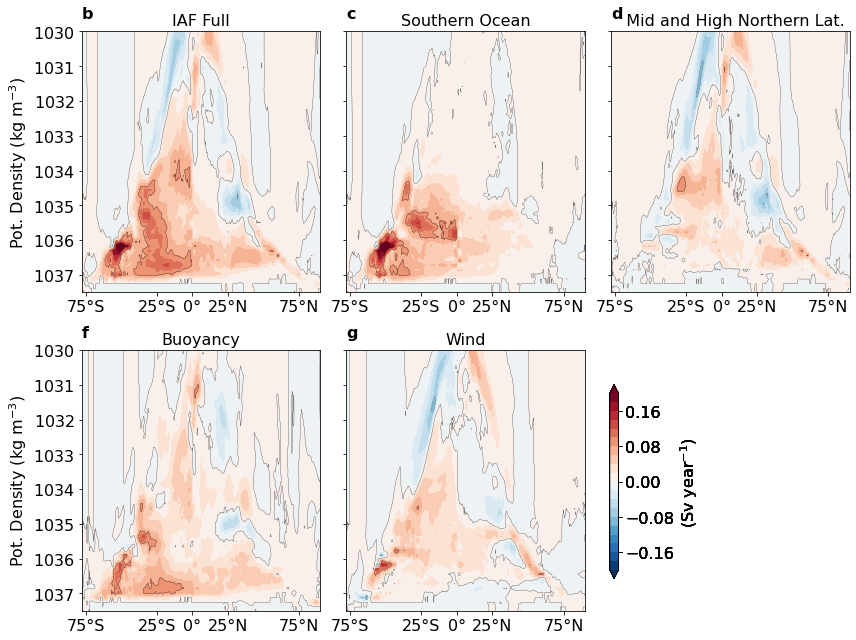

In [7]:
%%time
#yticks = [-3,0,5,10,15,20,25,30]
plot_range = [-80, 80]

suffix = ['ctrl_PI_Offset','iaf_PI_Offset','Southern_PI_Offset','Northern_PI_Offset','Tropics30SN_PI_Offset',
          'Wind_PI_Offset','TempRad_PI_Offset','Pacific_PI_Offset','Indian_PI_Offset','Atlantic_PI_Offset']

# initialise figure
fig = plt.figure(figsize=(12, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3) 

# def fancy_plot(data, title): # initialise fancy_plot function
for f in [1,2,3,5,6]:
    if f == 1:
        title = 'IAF Full'
        panel = gs[0,0]  
        ticks = np.linspace(-.2,.2,21); cont =[-.16,-.08,0,.08,.16]
    if f == 2:
        title = 'Southern Ocean'
        panel = gs[0,1]  
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
    if f == 3:
        title = '  Mid and High Northern Lat.'
        panel = gs[0,2]  
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
    if f == 5:
        title = 'Buoyancy'
        panel = gs[1,0]  
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
    if f == 6:
        title = 'Wind'
        panel = gs[1,1]  
        ticks = np.linspace(-.2,.2,21); cont = [-.16,-.08,0,.08,.16]
            
    data =  xr.open_dataset(base+out+'trend_overturning_streamfunction_'+suffix[f]+'.nc').psi_avg[0,:,:].sum(['xt_ocean'])
     
    unit = 'Sv year$^{-1}$'
    ax1 = plt.subplot(panel)
    p1=ax1.contourf(data.yt_ocean,data.potrho, data, cmap='RdBu_r', levels=ticks, extend='both')
#     if f in [4]:
#         # add colour bar
#         cb=plt.colorbar(p1,orientation='vertical', shrink = .75);
#         cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
#         cb.locator = tick_locator;cb.update_ticks() 
          
    
    # line contours
    p11a = ax1.contour(data.yt_ocean,data.potrho, data, levels=cont, colors='k', linewidths=0.25)
#     p11 = ax1.contour(data.yt_ocean,data.potrho, data, levels=[0,], colors='k', linewidths=0.5)
    cb.add_lines(p11a); #cb.add_lines(p11) # add contours to colour bar
    
    ax1.set_ylim([1030,1037.5]) # y axis limits
    plt.xticks(fontsize=16); plt.yticks(fontsize=16) # ticklabel  size
    ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
    ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent
    ax1.set_ylabel('Pot. Density (kg m$^{-3}$)', fontsize=16) # y axis label
    ax1.set_xticks([-75,-25,0,25,75]) # set x ticks
    ax1.set_xticklabels(['75°S','25°S','0°','25°N','75°N'], minor=False) # x axis labels
    ax1.set_title(title, fontsize=16) # title
    ax1.text(0, 1.05,string.ascii_lowercase[f], transform=ax1.transAxes,size=16, weight='bold') # subplot label
    
    ax1.invert_yaxis()
    
    cb.set_label(label='('+unit+')', size=16)
    if f in [2,3,6]:
        ax1.set_yticklabels([]); ax1.yaxis.label.set_visible(False)
    if f == [1,2]:
        ax1.set_xticklabels([]); ax1.yaxis.label.set_visible(False) 
      
    # add colour bar 
    cax = fig.add_axes([.71, .1, .01, .3]) # position: [x0, y0, width, height]
    cb = plt.colorbar(p1, cax = cax, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(Sv year$^{-1}$)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks()


#     linie = plt.vlines(x=26, ymin=-2.75, ymax=33.75, color='grey', linewidth=1) # RAPID line at 26°N over the full temperature range
#     linie.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
#     txt = plt.text(26, -10, str(RAPID)+' '+unit, color = 'grey', fontsize = 16, horizontalalignment = 'center')
#     txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])  

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'ACCESS-OM2-1_overturning_streamfunction_iaf_perturbations', 
            dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #


### Final plot with RAPID time series
- Calculated as in Kiss et al. (2020), Fig. 8:
Annual mean upper overturning cell (AMOC) magnitude as a function of time, defined as the maximum value of the global
overturning streamfunction computed on density surfaces, measured at 26° N, integrated between 103° and 5°W and for potential density
classes that exceed 1035.5 kg m$^{-3}$.

CPU times: user 6.12 s, sys: 12.9 s, total: 19 s
Wall time: 17.1 s


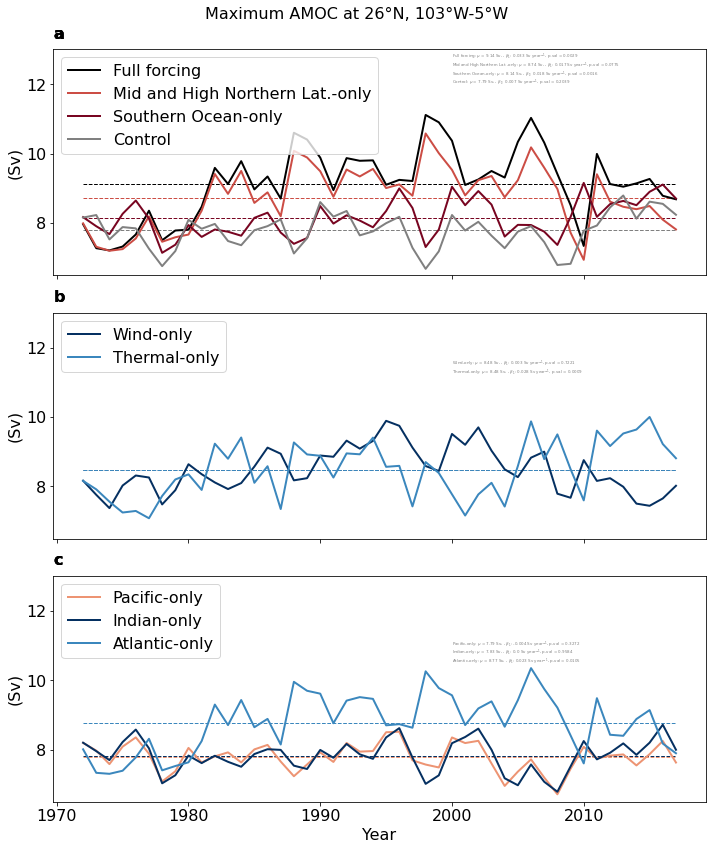

In [9]:
%%time        
suffix = ['iaf_PI_Offset','Northern_PI_Offset','Southern_PI_Offset','ctrl_PI_Offset','Tropics30SN_PI_Offset',
          'TempRad_PI_Offset','Wind_PI_Offset','Pacific_PI_Offset','Indian_PI_Offset','Atlantic_PI_Offset']
exp = ['Full forcing', 'Mid and High Northern Lat.-only', 'Southern Ocean-only', 'Control','Tropics30SN', 'Wind-only', 'Thermal-only',
      'Pacific-only','Indian-only','Atlantic-only']
farben = ['k',rotblau[4],rotblau[1],'grey',rotblau[6],rotblau[20],rotblau[16],
          rotblau[6],rotblau[20],rotblau[16]]
years = np.linspace(1972,2017,46)  

fig = plt.figure(figsize=(10,12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3, 1) 

  
# ax1.axhline(y=17.2, color=[0,.525,0], linewidth=2, label= 'McCarthy et al. (2015), observations') # AMOC OBS: 17.2 Sv

for f in [0,1,2,3,5,6,7,8,9]:
    if f in [0,1,2,3]:
        ax1 = plt.subplot(gs[0,0])
        ax1.text(0, 1.05,string.ascii_lowercase[0], transform=ax1.transAxes,size=16, weight='bold') # subplot label
        ax1.set_ylabel('(Sv)', fontsize=16); ax1.set_xticklabels([]);
    if f in [5,6]:
        ax1 = plt.subplot(gs[1,0])
        ax1.text(0, 1.05,string.ascii_lowercase[1], transform=ax1.transAxes,size=16, weight='bold') # subplot label
        ax1.set_xticklabels([]); ax1.set_ylabel('(Sv)', fontsize=16)
    if f in [7,8,9]:
        ax1 = plt.subplot(gs[2,0])
        ax1.text(0, 1.05,string.ascii_lowercase[2], transform=ax1.transAxes,size=16, weight='bold') # subplot label
        ax1.set_ylabel('(Sv)', fontsize=16); ax1.set_xlabel('Year', fontsize=16)
        
    data = xr.open_dataset(base+out+'overturning_streamfunction_'+suffix[f]+'.nc') # multiply with (-1) so that the NH overturning circulation
    data = data.where(data !=0).isel(yt_ocean=192).isel(xt_ocean=slice(171,278)) # -108°E (103°W) to -5°E (5°W) at RAPID array 26°N
    # to be sure I capture all ocen grid cells between Florida & Africa I take -108.5 to -2.5°W
    data = data.psi_avg.sum('xt_ocean').isel(potrho=slice(55,75)).max('potrho').load() # take sum over all longitude, take streamfunction above 1035.5 kg m**-3 
                                                                                        # and select each time step the maxima 

     # calculate the linear trend
    z1 = np.polyfit(years,data, 1) 
    stat = stats.linregress(years,data) # trend over 1972-2017 period
    p1 = np.poly1d(z1) # construct the polynomial 

        
    # plotting the data
    plt.plot(years, data,label=exp[f], # + r', trend: '+str(np.round(stat[0],3))+' Sv year$^{-1}$, ' + r'p-val = '+ str(np.round(stat[3],4)),
                color = farben[f], linewidth=2)
    plt.hlines(y=data.mean().values, xmin=years[0], xmax=years[-1], color = farben[f], linewidth = 1, linestyle = '--') # plot the mean AMOC
#     ax1.plot(years, p1(years), color = farben[f], linewidth=1, linestyle='--') # plotting the trend
    ax1.legend(fontsize=16, loc = 'upper left')
    
    # plotting the mean, trend and p-value over the full time series 
    plt.text(2000,12.75-0.25*f, exp[f] + ': $\mu$ = '+str(np.round(data.mean().values,2)) + ' Sv, ' + 
             r', $\beta_1$: '+str(np.round(stat[0],3))+' Sv year$^{-1}$, ' + r'p-val = '+ str(np.round(stat[3],4)), color='grey', fontsize=4, ha = 'left')
    
    plt.suptitle('Maximum AMOC at 26°N, 103°W-5°W', fontsize=16)
    ax1.set_ylim([6.5,13]) # y axis limits
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.locator_params(axis='x', nbins=7); plt.locator_params(axis='y', nbins=5) # seven ticks on x-axis and five on y-axis


# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'ACCESS-OM2-1_overturning_streamfunction_AMOC_maximum', 
            dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 11 s     

### Mean over the 2004-2017 period to compare with OBS
- McCarthy et al. (2015):        2004-2012 17.2 Sv
- Frajka-Williams et al. (2019): 2004-2017 17.0±4.4 Sv

[9.49, 9.31]

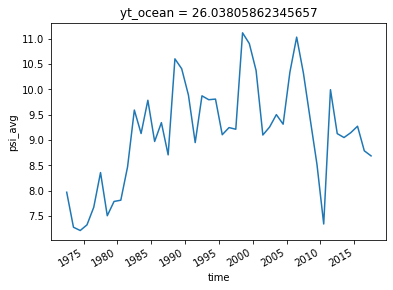

In [9]:
data = xr.open_dataset(base+out+'overturning_streamfunction_iaf_PI_Offset.nc')
data = data.where(data !=0).isel(yt_ocean=192).isel(xt_ocean=slice(171,278)).psi_avg.sum('xt_ocean').isel(potrho=slice(55,75)).max('potrho').load()
data.plot()
[np.round(data.isel(time=slice(32,41)).mean().values, 2), np.round(data.isel(time=slice(32,46)).mean().values, 2)] # select time period, take mean and round to two digits
# mean over 2004-2012       and              2004-2017

In [10]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #